In [5]:
!pip install datasets

DEPRECATION: Loading egg at /apps/python/3.12.0/lib/python3.12/site-packages/flann-1.9.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [6]:
!pip install timm

DEPRECATION: Loading egg at /apps/python/3.12.0/lib/python3.12/site-packages/flann-1.9.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached torch-2.4.0-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux

In [ ]:
!pip install transformers==4.40.*

DEPRECATION: Loading egg at /apps/python/3.12.0/lib/python3.12/site-packages/flann-1.9.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
from torchvision.transforms import v2
from huggingface_hub import notebook_login
from huggingface_hub import HfApi

# For displaying:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
torch.__version__, transformers.__version__

('2.1.1', '4.40.2')

In [10]:
mbatch_size = 2

In [11]:
# Device:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
# Load model:
tokenizer = transformers.AutoTokenizer.from_pretrained('aehrc/cxrmate-rrg24')
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-rrg24', trust_remote_code=True).to(device=device)
model.eval()

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Resize(size=model.config.encoder.image_size, antialias=True),
        v2.CenterCrop(size=[model.config.encoder.image_size]*2),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=model.config.encoder.image_mean, std=model.config.encoder.image_std),
    ]
)
        

/apps/python/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/apps/python/3.12.0/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [13]:
# HF token for accessing the dataset:
api = HfApi()
try:
    user_info = api.whoami()
    if not user_info:
        print("No user token found. Please log in.")
        notebook_login()
        user_info = api.whoami()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    notebook_login()

In [14]:
# Data:
dataset = datasets.load_dataset('StanfordAIMI/interpret-cxr-test-public', token=True)['test']

def transform_batch(batch):
    batch['images'] = [torch.stack([transforms(j) for j in i]) for i in batch['images']]
    batch['images'] = torch.nn.utils.rnn.pad_sequence(batch['images'], batch_first=True, padding_value=0.0)  
    return batch

dataset = dataset.with_transform(transform_batch)
dataloader = DataLoader(dataset, batch_size=mbatch_size, shuffle=True)
batch = next(iter(dataloader))

/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/apps/python/3.12.0/lib/python3.12/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


'Study 1:'

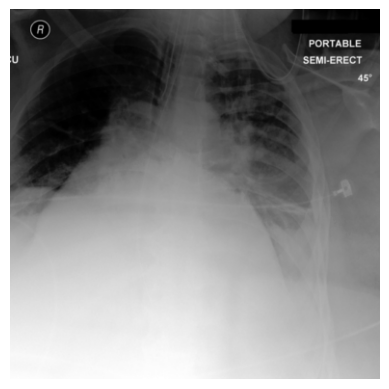

'Study 2:'

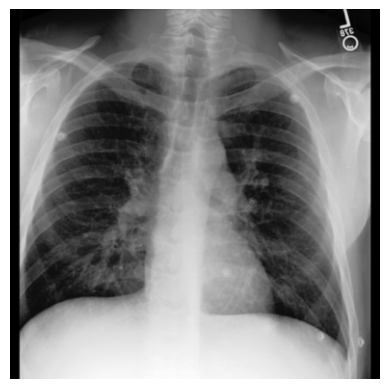

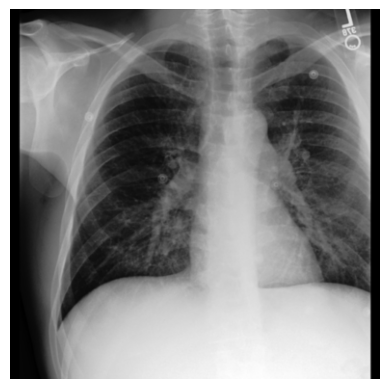

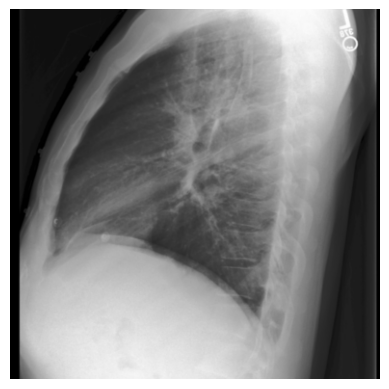

In [15]:
# Display images:
for i, j in enumerate(batch['images']):
    display(f'Study {i+1}:')
    for k in j:
        if not torch.all(k == 0):
            image = k.numpy()
            for channel in range(image.shape[0]):
                image[channel] -= image[channel].min()
                image[channel] /= image[channel].max()
            image = (image * 255).astype(np.uint8)
            plt.imshow(image.transpose(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.show()

In [16]:
# Generate findings only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')]],
    eos_token_id=tokenizer.sep_token_id
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\n') for i in findings]

Findings:
	It is compared with the radiograph from november 5, 2020. no significant changes are observed in relation to the previous study. the right pleural effusion and the left pleural effusion are not present in the previous study. no additional consolidations are observed.

Findings:
	 reported study compared to the 2nd chest x-ray 15 03 2020. no pulmonary consolidations are identified in the current x-ray. cardiomedastinal silhouette and pulmonary hila of normal size and morphology. there are no radiological signs of pleural effusion. no other alterations in lung parenchyma are observed. no other significant findings. marked scoliosis of the thoracolumbar spine.



In [17]:
# Generate impression only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NI]')]],
    input_ids=torch.tensor([[tokenizer.bos_token_id, tokenizer.convert_tokens_to_ids('[NF]'), tokenizer.sep_token_id]]*mbatch_size, device=device, dtype=torch.long),
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Impression:\n\t{i}\n') for i in impression]

Impression:
	1. SINGLE FRONTAL VIEW OF THE CHEST DEMONSTRATES NO EVIDENCE OF PNEUMOTHORAX. 2. STABLE CARDIOMEGALY. 3. STABLE SMALL BILATERAL PLEURAL EFFUSIONS. 4. LEFT MID LUNG OPACITY, WHICH MAY REPRESENT ATELECTASIS, INFECTION, OR ASPIRATION. 5. STABLE LEFT PERIHILAR OPACITY, WHICH MAY REPRESENT ATELECTASIS, CONSOLIDATION, OR ASPIRATION. 6. STABLE SMALL LEFT PLEURAL EFFUSION.

Impression:
	 from cardiac silhouette. The right lung is clear and there is no pleural effusion. The findings were discussed with Dr ___ at 17:00 on the room of the exam by Dr ___



In [18]:
# Generate both sections:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')], [tokenizer.convert_tokens_to_ids('[NI]')]],
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\nImpression:\n\t{j}\n') for i,j in zip(findings, impression)]

Findings:
	Bilateral pulmonary opacities predominantly in the left upper lung field. alveolar opacity in the left lower lobe. cardiomegaly. pinching of the left costophrenic sinus. no other alterations in the right lung. to be correlated with clinical findings. right pleural effusion. no pneumothorax. conclusion: findings are consistent with covid-19. increase in size of the left pleural effusion compared to the study of the date. right pleural effusion. cardiomedastinal silhouette and pulmonary hila of normal size and morphology. no alterations in the left lung. no alterations in the right lung parenchyma and in the left upper lung field. left pleural effusion. no other alterations. conclusion: findings suggestive of bilateral covid-19 pneumonia. suspicion of left pleural effusion. indeterminate findings of covid-19 infection. to be correlated with clinical findings and progression of the left pleural effusion. no pleural effusion in the right lung field. infiltrate in the left lung f